# Design draft

In [15]:
import pamtra2
import collections
import refractiveIndex
import numpy as np
import pandas as pn
import xarray as xr
from collections import OrderedDict
from copy import deepcopy, copy
import toolz
import collections
import matplotlib.pyplot as plt

try:
    %matplotlib inline
except:
    pass

In [16]:
import pyPamtraRadarSimulator



# create Profile

In [17]:
additionalDims = collections.OrderedDict()
additionalDims['time'] = pn.date_range('2016-01-01','2016-01-05',freq='D')[:1]
additionalDims['lat'] = np.arange(70,80)
nHeights = 100

pam2 = pamtra2.pamtra2(
    nLayer=nHeights,
    hydrometeors=['rain','snow'],
    additionalDims = additionalDims,
    frequencies = [35e9, 94e9],
)



In [18]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 10, layer: 100, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 nan nan nan nan nan nan ...
    temperature          (time, lat, layer) float64 nan nan nan nan nan nan ...
    pressure             (time, lat, layer) float64 nan nan nan nan nan nan ...
    relativeHumidity     (time, lat, layer) float64 nan nan nan nan nan nan ...
    horizontalWind       (time, lat, layer) float64 nan nan nan nan nan nan ...
    verticalWind         (time, lat, layer) float64 nan nan nan nan nan nan ...
    eddyDissipationRate  (time, lat, layer) float64 nan na

In [19]:

pam2.profile.height[:] = np.linspace(0,1000,nHeights)
pam2.profile.temperature[:] = 250 
pam2.profile.relativeHumidity[:] = 90
pam2.profile.pressure[:] = 10000
pam2.profile.eddyDissipationRate[:] = 1e-4
pam2.profile.horizontalWind[:] = 0



pam2.profile.waterContent.values[:] = 0
#rain
pam2.profile.waterContent.values[:,:,20:40,0] = 1e-4
#snow
pam2.profile.waterContent.values[:,:,20:40,1] = 2e-4

pam2.profile = pam2.profile.chunk({'time':1, 'hydrometeor':1, 'lat':1, 'frequency':1})

pam2.profile 



<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 10, layer: 100, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    temperature          (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    pressure             (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    relativeHumidity     (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    horizontalWind       (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    vert

In [20]:
# # OR EASIER if desired: 
# pam2 = pamtra2.importers.profiles.usStandardAtmosphere(heigths)

In [21]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 10, layer: 100, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    temperature          (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    pressure             (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    relativeHumidity     (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    horizontalWind       (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    vert

# Describe Hydrometeors

In [22]:

pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'rain', #or None, then str(index)
    kind = 'liquid', #liquid, ice
    nBins =40,
    sizeCenter = pamtra2.hydrometeors.sizeCenter.linspace, 
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.exponentialN0WC, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = pamtra2.hydrometeors.density.water,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    refractiveIndex = refractiveIndex.water.n, #replace with refractiveIndex.water.Turner.n
    scattering = pamtra2.scattering4Pamtra.Rayleigh,
    Dmin  = 1e-6,
    Dmax  = 1e-2,
    N0 =  8e6,
    model = 'Turner',
    useFuncArgDefaults = True,
)


sizeCenter <function linspace at 0x11c6b77b8>
callable
aspectRatio 1.0
not callable 1.0
density 1000.0
not callable 1000.0
mass <function ellipsoid at 0x11cc4f840>
callable
crossSectionArea <function sphere at 0x11cc4fe18>
callable
sizeDistribution <function exponentialN0WC at 0x11cc4fb70>
callable
refractiveIndex <function n at 0x41e355620>
callable
scattering <function Rayleigh at 0x11cc55a60>
callable
kind liquid
not callable liquid
Dmin 1e-06
not callable 1e-06
Dmax 0.01
not callable 0.01
N0 8000000.0
not callable 8000000.0
model Turner
not callable Turner


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [23]:
pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidMassSize,
    name='snow',
    nBins = 20,
    sizeCenter=pamtra2.hydrometeors.sizeCenter.logspace, #function/object to call for getting sizes
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.exponentialFieldWC,
    aspectRatio = 0.6,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.powerLaw,
    mass = pamtra2.hydrometeors.mass.powerLaw,
    density = pamtra2.hydrometeors.density.softEllipsoid,
    #to do: adapt refractiveIndex routine so that mixing and RI are treated separately. 
    refractiveIndex = refractiveIndex.snow.n,
    scattering = pamtra2.scattering4Pamtra.Mie,
    Dmin = 1e-6,
    Dmax = 1e-2,
    massSizeA = 0.0121, 
    massSizeB = 1.9,
    areaSizeA = 0.01,
    areaSizeB = 1.8,
    minDensity = 100,
    bla = 12,
    useFuncArgDefaults = True,
    )


sizeCenter <function logspace at 0x11c6b7840>
callable
aspectRatio 0.6
not callable 0.6
mass <function powerLaw at 0x11c6b7a60>
callable
density <function softEllipsoid at 0x11cc4ff28>
callable
crossSectionArea <function powerLaw at 0x11cc4fd90>
callable
sizeDistribution <function exponentialFieldWC at 0x11cc4fa60>
callable
refractiveIndex <function n at 0x41e34be18>
callable
scattering <function Mie at 0x11cc55840>
callable
Dmin 1e-06
not callable 1e-06
Dmax 0.01
not callable 0.01
massSizeA 0.0121
not callable 0.0121
massSizeB 1.9
not callable 1.9
areaSizeA 0.01
not callable 0.01
areaSizeB 1.8
not callable 1.8
minDensity 100
not callable 100
bla 12
not callable 12


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [24]:
pam2.hydrometeors.rain.profile

<xarray.Dataset>
Dimensions:                  (frequency: 2, lat: 10, layer: 100, sizeBin: 40, time: 1)
Coordinates:
  * sizeBin                  (sizeBin) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * time                     (time) datetime64[ns] 2016-01-01
  * lat                      (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer                    (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * frequency                (frequency) float64 3.5e+10 9.4e+10
Data variables:
    sizeCenter               (sizeBin) float64 1e-06 0.0002574 0.0005138 ...
    aspectRatio              float64 1.0
    density                  float64 1e+03
    mass                     (sizeBin) float64 5.236e-16 8.928e-09 7.101e-08 ...
    crossSectionArea         (sizeBin) float64 7.854e-25 3.447e-15 5.472e-14 ...
    sizeDistribution         (sizeBin, time, lat, layer) float64 dask.array<shape=(40, 1, 10, 100), chunksize=(40, 1, 1, 100)>
    refractiveIndex          (time, lat, layer, frequency) 

# Radar simulator

**so far just to figure out how to get things going!!!**

In [25]:
def calcSpectralBroadening(
    profile,
    beamwidthDeg=0.2,
    integrationTime=60,
):
    
    # is the broadcast step really required?
#     profile = xr.broadcast(profile[
#         ['height','eddyDissipationRate','horizontalWind','frequency']
#     ])[0].stack(
#         merged=list(pam2.additionalDims.keys())+['layer','frequency']
#     )

    kwargs = {
        'beamwidthDeg':beamwidthDeg,
        'integrationTime': integrationTime,
    }

    coreDims = []
    thisVars = ['height','eddyDissipationRate','horizontalWind','wavelength']
    
    profile = profile[thisVars]
    arrDims = list(profile.dims.keys())
    for cc in coreDims:
        arrDims.remove(cc)
        
    profile = profile.stack(
        merged=arrDims
    )
    
    sb = xr.apply_ufunc(
    pyPamtraRadarSimulator.calcSpectralBroadening,
        profile.eddyDissipationRate,
        profile.horizontalWind,
        profile.height,
        profile.wavelength,
        kwargs = kwargs,
        dask ='parallelized',
        output_dtypes = [profile.eddyDissipationRate.dtype],
    #     vectorize = True
    )

    return sb.unstack('merged')

pam2.profile['spectralBroadening'] = calcSpectralBroadening(
    pam2.profile,
    )
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 10, layer: 100, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    temperature          (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    pressure             (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    relativeHumidity     (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    horizontalWind       (time, lat, layer) float64 dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>
    vert

In [26]:
pam2.profile['pathIntegratedAtenuattion'] = xr.zeros_like(pam2.profile.height)


In [22]:
radarSpecs = []
for name in ['snow','rain']:
    def calcRadarSpectrum(
        fallVelocityRelation ='heymsfield10_particles',
        radarMaxV =7.885,
        radarMinV =-7.885,
        radarAliasingNyquistInterv = 1,
        radarNFFT = 256,
        verbosity = 0,
        radarAirmotion = True,
        radarAirmotionModel = "constant", #"constant","linear","step"
        radarAirmotionVmin = 0,
        radarAirmotionVmax = 0,
        radarAirmotionLinearSteps = 30,
        radarAirmotionStepVmin = 0.5,
        radarK2 =0.93, # dielectric constant |K|² (always for liquid water by convention) for the radar equation
    ):

        #order matters!
        hydroVars = [
            'sizeCenter',
            'backScatteringCrossSection',
            'mass',
            'density',
            'crossSectionArea',
        ]
        profileVars = [
            'height',
            'temperature',
            'pressure',
            'verticalWind',
            'wavelength',   
        ]

        mergedProfile = pam2.hydrometeors[name].getProfileWithParentAllBroadcasted(
            variables=hydroVars,
            parentVariables=profileVars,
            exclude=['sizeBin'],
        )
        mergedProfile = mergedProfile.stack(merged=pamtra2.helpers.concatDicts(pam2.coords['additional'],pam2.coords['layer'],pam2.coords['frequency']))


        args = []
        for var in hydroVars+profileVars:
            args.append(mergedProfile[var])

        input_core_dims = []
        for arg in args:
            this_core_dims = []
            for coreDim in ['sizeBin']:
                if coreDim in arg.dims:
                    this_core_dims.append(coreDim)
            input_core_dims.append(this_core_dims)

        kwargs = dict(
            fallVelocityRelation =fallVelocityRelation,
            radarMaxV =radarMaxV,
            radarMinV =radarMinV,
            radarAliasingNyquistInterv = radarAliasingNyquistInterv,
            radarNFFT = radarNFFT,
            verbosity =verbosity,
            radarAirmotion = radarAirmotion,
            radarAirmotionModel = radarAirmotionModel, #"constant","linear","step"
            radarAirmotionVmin = radarAirmotionVmin,
            radarAirmotionVmax = radarAirmotionVmax,
            radarAirmotionLinearSteps = radarAirmotionLinearSteps,
            radarAirmotionStepVmin = radarAirmotionStepVmin,
            radarK2 =radarK2, 
        )    

        nfft = radarNFFT *(1+2*radarAliasingNyquistInterv)

        radarSpec = xr.apply_ufunc(
        pyPamtraRadarSimulator.createRadarSpectrum,
            *args,
            kwargs = kwargs,
            input_core_dims = input_core_dims,
            output_core_dims = [('radarNfftAliased',)],
            output_dtypes = [mergedProfile.backScatteringCrossSection.dtype],
            output_sizes = {'radarNfftAliased':nfft},
            dask = 'parallelized',
        ).unstack('merged')

        return radarSpec
    radarSpec =calcRadarSpectrum()
    
    radarSpec.compute()
    
    radarSpecs.append(radarSpec)
radarSpecs = xr.concat(radarSpecs,dim='hydrometeor')
radarSpecs = radarSpecs.sum('hydrometeor')


pam2.profile['radarIdealizedSpectrum'] = radarSpecs
pam2.profile['radarIdealizedSpectrum']

<xarray.DataArray 'radarIdealizedSpectrum' (radarNfftAliased: 768, time: 1, lat: 10, layer: 100, frequency: 2)>
array([[[[[0., 0.],
          ...,
          [0., 0.]],

         ...,

         [[0., 0.],
          ...,
          [0., 0.]]]],



       ...,



       [[[[0., 0.],
          ...,
          [0., 0.]],

         ...,

         [[0., 0.],
          ...,
          [0., 0.]]]]])
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01
  * lat        (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer      (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * frequency  (frequency) float64 3.5e+10 9.4e+10
Dimensions without coordinates: radarNfftAliased

In [34]:
pam2.profile

<xarray.customProfile>
Dimensions:                    (frequency: 2, hydrometeor: 2, lat: 10, layer: 100, radarNfftAliased: 768, time: 1)
Coordinates:
  * time                       (time) datetime64[ns] 2016-01-01
  * lat                        (lat) int64 70 71 72 73 74 75 76 77 78 79
  * layer                      (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * hydrometeor                (hydrometeor) <U4 'rain' 'snow'
  * frequency                  (frequency) float64 3.5e+10 9.4e+10
Dimensions without coordinates: radarNfftAliased
Data variables:
    height                     (time, lat, layer) float64 0.0 10.1 20.2 30.3 ...
    temperature                (time, lat, layer) float64 250.0 250.0 250.0 ...
    pressure                   (time, lat, layer) float64 1e+04 1e+04 1e+04 ...
    relativeHumidity           (time, lat, layer) float64 90.0 90.0 90.0 ...
    horizontalWind             (time, lat, layer) float64 0.0 0.0 0.0 0.0 ...
    verticalWind               (time, la

In [24]:
def simulateRadarSpec(
  fallVelocityRelation='heymsfield10_particles',
  radarMaxV=7.885,
  radarMinV=-7.885,
  radarAliasingNyquistInterv=1,
  radarNFFT=256,
  radarPNoise1000=-30,
  radarK2=0.93,# dielectric constant |K|² (always for liquid water by convention) for the radar equation
  radarNAve=150,
  seed=0,
  verbosity=0
  ):
    
    
    kwargs = dict(
      fallVelocityRelation=fallVelocityRelation,
      radarMaxV=radarMaxV,
      radarMinV=radarMinV,
      radarAliasingNyquistInterv=radarAliasingNyquistInterv,
      radarNFFT=radarNFFT,
      radarPNoise1000=radarPNoise1000,
      radarK2=radarK2,
      radarNAve=radarNAve,
      seed=seed,
      verbosity=verbosity
    )
    
    variables = [
        'height',
        'radarIdealizedSpectrum',
        'pathIntegratedAtenuattion',
        'spectralBroadening',
        'wavelength',
    ]
    mergedProfile = pam2.profile[variables]
    
    mergedProfile = mergedProfile.stack(
        merged=pamtra2.helpers.concatDicts(
            pam2.coords['additional'],
            pam2.coords['layer'],
            pam2.coords['frequency'])
    )


    args = []
    for var in variables:
        args.append(mergedProfile[var])
    
    input_core_dims = []
    for arg in args:
        this_core_dims = []
        for coreDim in ['radarNfftAliased']:
            if coreDim in arg.dims:
                this_core_dims.append(coreDim)
        input_core_dims.append(this_core_dims)
    
    radarSpec = xr.apply_ufunc(
    pyPamtraRadarSimulator.simulateRadarSpectrum,
        *args,
        kwargs = kwargs,
        input_core_dims = input_core_dims,
        output_core_dims = [('radar_nfft',)],
        output_dtypes = [mergedProfile.radarIdealizedSpectrum.dtype],
        output_sizes = {'radar_nfft':256},
        dask = 'parallelized',
    ).unstack('merged')

    return radarSpec
radarSpec = simulateRadarSpec()



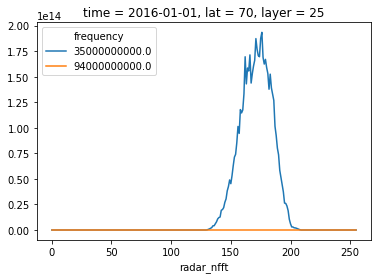

In [25]:
(radarSpec).isel(time=0,layer=25,lat=0).plot.line(x='radar_nfft')

# Original concept

In [27]:

#this function will add hydrometeor confihuration to pam2.hydrometeors and 
#append hydrometeor to coordinates of e.g. pam2.profile.lwc
#Note that only the configuration will stored! All the functions
#will be calles later by the forward model! 
pam2.addHydrometeor(
    name = 'snow1', #or None, then str(index)
    index = 0, #or None, then append
    kind = 'snow', #liquid, ice
    nBins = 80,
    sizes = (
        pamtra2.hydrometeors.sizes.logspace, #function/object to call for getting sizes
        funcArgs = {
            Dmin = 1e-6,
            Dmax = 1e-4,
        }
    ),
    psd = (
        pamtra2.hydrometeors.sizeDistributions.exponentialFieldLwc, #function/object to call for getting psd
        funcArgs = {
            temperature : pam2.profile.temperature,
            lwc : pam2.profile.lwc, #test whether hydrodim is included! for all input vars!
            massSizeA : 0.01, #mass size relation required to estimate exponential doistribution from N0
            massSizeB : 1.8,
        },
    ),
    aspectRatio = (
        0.6,
    ),
    mass = (
        pamtra2.hydrometeors.mass.powerLaw, #function/object to call for getting mass
        funcArgs = {
            massSizeA : 0.01,
            massSizeB : 1.8,
        },
    ),
    density = (
        pamtra2.hydrometeors.density.softSphere, #function/object to call for getting density
        funcArgs = {
            minDensity : 100,
#             maxDensity : , defaults to ice!
        },
    ),
    crossSectionArea = (
        pamtra2.hydrometeors.area.powerLaw, #function/object to call for getting crossSectionArea
        funcArgs = {
            areaSizeA : 0.01,
            areaSizeB : 1.8,
        },
    ),
)
#for example, pamtra2.hydrometeors.area.powerLaw will be an object
# which will be called with pamtra2.hydrometeors.area.powerLaw(diameterCenter,
# areaSizeA=areaSizeA,areaSizeB=areaSizeB)



pam2.addHydrometeor(
    name = 'rain1', #or None, then str(index)
    index = 1, #or None, then append
    kind = 'liquid', #liquid, ice
    nBins =40,
    sizes = (
        pamtra2.hydrometeors.sizes.linspace, 
        funcArgs = {
            Dmin = 1e-6,
            Dmax = 1e-4,
        }
    ),
    psd = (
        pamtra2.hydrometeors.sizeDistributions.exponentialLwc, #function/object to call for getting psd
        funcArgs = {
            lwc : pam2.profile.lwc, #test whether hydrodim is included! for all input vars!
            lambd : 10,
        },
    ),
    aspectRatio = (
        pamtra2.hydrometeors.aspectRatio.rainAspectRatioModel,
        funcArgs = {
            sampleKeyword : 10, 
        },
    ),
    mass = (
        pamtra2.hydrometeors.mass.ellipsoid,
    ),
    density = (
        pamtra2.hydrometeors.density.water, # or 1000.
    ),
    crossSectionArea = (
        pamtra2.hydrometeors.area.ellipsoid,
    ),
)

#in case we already have the full spectrum!

pam2.addHydrometeor(
    name = 'ice1', #or None, then str(index)
    index = 1, #or None, then append
    kind = 'liquid', #liquid, ice
    nBins =2,
    sizes = (
        pamtra2.hydrometeors.sizes.monodispers, 
        funcArgs = {
            Dmono = 1e-5,
        },
    ),
    psd = (
        pamtra2.profiles.hydrometeor_size_distribution, #array with discrete n(D) exists, but has len ==0.
    ),
    aspectRatio = (
        1.0,
    ),
    mass = (
        pamtra2.hydrometeors.mass.ellipsoid,
    ),
    density = (
        pamtra2.hydrometeors.density.ice, # or 971.
    ),
    crossSectionArea = (
        pamtra2.hydrometeors.area.ellipsoid,
    ),
)
#now the array is prepared because addHydrometeor got an array as an argumetn for psd
pam2.profiles.hydrometeor_size_distribution.sel(hydrometeor='ice1')[:] = ICE_PSD_FROM_AIRCRAFT


#now also profile.lwc is prepare because we know how many hydrometeors we have:
pam2.profile.lwc[:] = 0.1


# OR EASIER for all of the above: 
pamtra2.importer.profiles.CosmoColumsNetcdf('COSMO_column_20170102.nc') #will take care of hydrometeors and profiles


#kazr is a copy of the pam object with added information about the instrument
kazr = pam2.createInstrument(
    name= 'KAZR'
    kind = 'dopplerRadar',
    #the pamtra2.forwardOperators.spectralRadarSimulator class will contain all the magic and create the object to be retruend
    method = pamtra2.forwardOperators.spectralRadarSimulator, 
    frequencies = [35],
    settings = {
        'nyquistVMax' : 10,
        'nyquistVMin' : -10,
        'nFFT' : 512,
        'K2': 0.92,
        ...
    }
)


#add information about scattering properties
kazr.setHydrometeorScattering(
    'rain1',
    refractiveIndex = (
        pamtra2.refractiveIndex.water, 
        funcArgs = {
            'model' : 'Turner',
        }
    ),
    singleScattering = (
        pamtra2.singleScattering.tmatrix, 
        funcArgs = {
            'cached' : True,
        },
    ),
)

kazr.setHydrometeorScattering(
    'snow1', 
    refractiveIndex = (
        pamtra2.refractiveIndex.snow, 
        funcArgs = {
            'model_mix':'Bruggeman',
            'model_ice':'Matzler_2006',
        }
    ),
    singleScattering = (
        pamtra2.singleScattering.rayleighGans, 
        funcArgs = {
        },
    ),
)

kazr.setHydrometeorScattering(
    'ice1',
    # refractiveIndex = (), For missing descriptions, default values 
    # will be used depending on particle kind!
    # singleScattering = (
    #     pamtra2.singleScattering.mie, 
    # ),
)


hatpro = pam2.createInstrument(
    name= 'Hatpro'
    kind = 'MWR',
    #pamtra2.forwardOperators.RT4 will share a lot of code with pamtra2.forwardOperators.spectralRadarSimulator
    method = pamtra2.forwardOperators.RT4, 
    frequencies = [22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.40],
    settings = {
        'bandWidths' : [0.230, 0.230, 0.230, 0.230, 0.230, 0.230, 0.230],
        ....
    }
)

#We can either copy the scattering properties or do new ones!
hatpro.setHydrometeorScattering(
...
)



ceilo = pam2.createInstrument(
    name= 'Ceilo'
    kind = 'Ceilometer',
    method = pamtra2.forwardOperators.Ceilosim, 
    wavelengths = [905],
    settings = {
        'property' : 10,
        ...
    }
)

ceilo.setHydrometeorScattering(
...
)

# OR EASIER: 
WSACR = pamtra.importer.instruments.WSACR(site='Oliktok Point',configuration='20171004')
WSACR.setHydrometeorScattering(
...
)



kazr.run() #this command runs all the functions defined above!
kazr.results.to_netcdf('kazr.nc')

hatpro.run()
hatpro.results.to_netcdf('hatpro.nc')

ceilo.run()
ceilo.results.to_netcdf('ceilo.nc')

SyntaxError: invalid syntax (<ipython-input-27-51cfb8e86fe3>, line 13)

In [ ]:
%debug

In [ ]:
np.array(list(map(lambda x,y:x+y**2,np.random.random((10,10)),np.random.random((10,10)))))

In [ ]:
np.asarray(pam2.profile.temperature)

In [ ]:
hyd.discreteProperties.aspectRatio.max()

In [ ]:
import numba

@numba.jit(nopython=False)
def modifiedGamma(sizeCenter,N0,lambd,mu=0,gamma=1):
  """
  classical modifed gamma distribution

  Parameters
  ----------
  sizeCenter : array_like
    particle size at center of size bin
  N0 : array_like
    N0 prefactor (default None)
  lambd : float or array_like
    lambda parameter (default array)
  mu : float or array_like
    mu parameter (default array)
  gamma : float or array_like
    gamma parameter (default array)

  Returns
  -------

  N : array
    particle size distribution with shape = N0.shape + sizeCenter.shape
  """

  N = N0 * sizeCenter**mu * np.exp(-lambd * sizeCenter**gamma)

  return N

In [ ]:



sizeCenter=np.zeros((1000,10,4))
sizeCenter[:] = np.logspace(-6,-2,4)
# sizeCenter =np.logspace(-6,-2,100).reshape((1000,10))
N0 = np.random.random((1000,10))
lambd = np.random.random((1000,10))

# vecFunc = np.vectorize(lambda sizeCenter,N0,lambd : modifiedGamma(sizeCenter,N0,lambd))


%timeit modifiedGamma(sizeCenter.T,N0.T,lambd.T).T